In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# dark channel Prior
def get_darkChannel(img, radii):

    # split the original image to three channels
    r, g, b = cv2.split(img)

    # get the image dark channel
    dc = cv2.min(cv2.min(r, g), b)

    # get the local area min value like erode in single channle image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radii, radii))
    dc = cv2.erode(dc, kernel)

    return dc

# guided Filter
def guidedFilter(img_i, img_g, radii, epsilon):

    # get the mean and correlation of the img_in and img_guide with the specific area 
    i_mean = cv2.boxFilter(img_i, cv2.CV_64F, (radii, radii))
    g_mean = cv2.boxFilter(img_g, cv2.CV_64F, (radii, radii))
    ig_mean = cv2.boxFilter(img_i*img_g, cv2.CV_64F, (radii, radii))
    ii_mean = cv2.boxFilter(img_i*img_i, cv2.CV_64F, (radii, radii))

    # get the variance and co-variance
    var_ii = ii_mean - i_mean*i_mean
    cor_ig = ig_mean - i_mean*g_mean

    # get the optimal parameters
    alpha = cor_ig / (var_ii + epsilon)
    beta = g_mean - alpha * i_mean

    # get the mean value
    a_mean = cv2.boxFilter(alpha, cv2.CV_64F, (radii, radii))
    b_mean = cv2.boxFilter(beta, cv2.CV_64F, (radii, radii))

    # get the result

    return a_mean*img_i + b_mean

# Estimating the Atmospheric Light
def get_atmosphericLight(img, dc):

    # get the top 0.1% brightest pixels in the dark channel
    h, w = img.shape[:2]

    top_pixels = max(h*w // 1000, 1)
    dc_vec, img_vec = dc.reshape(h*w), img.reshape(h*w, 3)

    ind_pixels = np.argsort(dc_vec)[h*w-top_pixels:]
    
    # find the brightest pixels in the image
    A = np.zeros((3, ))
    A[0] = np.max(img_vec[ind_pixels][0])
    A[1] = np.max(img_vec[ind_pixels][1])
    A[2] = np.max(img_vec[ind_pixels][2])

    return A

# estimating the transmission
def get_transmission(img, A, radii, omega=0.95):

    # normalize the img with the Atmospheric light
    img_norm = img / A

    # get the dark channel of the normalized img
    dc_norm = get_darkChannel(img_norm, radii)

    # caculate the transmission
    t = 1 - omega*dc_norm

    return t

def refine(img, et):

    # convert the image from RGB to GRAY
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # convert the data type from integer 0-255 to float 0-1
    gray = np.float64(gray)/255
    r = 60
    eps = 0.0001
    t = guidedFilter(gray,et,r,eps)

    return t

def recover(img, t, A, tx=0.1):
    res = np.empty(img.shape, img.dtype)
    t = cv2.max(t, tx)
    for i in range(3):
        res[:,:,i] = (img[:,:,i]-A[i])/t + A[i]
    
    return res

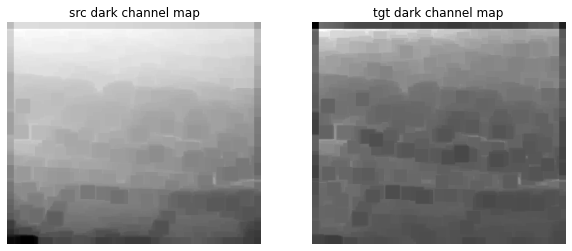

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


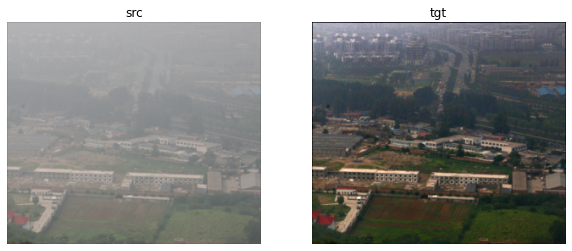

In [3]:
# test of the img
import os
import glob
filedir = '.'
filename = '*'
fileend = ['.png']
filepath = []
for end in fileend:
    files = glob.glob(os.path.join(filedir, filename+end))
    for file in files:
        filepath.append(file)

for img_path in filepath:
    src = cv2.imread(img_path)
    I = src.astype('float64')/255
 
    dark = get_darkChannel(I,15)
    A = get_atmosphericLight(I,dark)
    te = get_transmission(I,A,15)
    t = refine(src,te)
    J = recover(I,t,A)

    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(dark, cmap='gray')
    plt.title('src dark channel map')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(get_darkChannel(J, 15), cmap='gray')
    plt.title('tgt dark channel map')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(src[:, :, ::-1])
    plt.title('src')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(J[:, :, ::-1])
    plt.title('tgt')
    plt.axis('off')
    plt.show()